# Benchmarking result visualization

## Outline

The **MLAging - benchmarking** workflow consists of sections:

`510 Benchmark BiT Rep` Recapitulating the results from [BiT: Meyer and Schumacher; PMID: 33656257](https://github.com/Meyer-DH/AgingClock/).

`511 Bechmarking BiT Median` ELN model using *binarized* HVGs. The binarization threshold is median value, which was implemented in the BiT.

`521 Bechmarking Bootstrap_clock Bootstrap.R` Boostrap major cell types in the hypothalamus dataset using the codes from [Bootstrap_clock: Buckley et al; PMID: 37118510](https://github.com/sunericd/svz_singlecell_aging_clocks/tree/main/00_core/01_clocks/00_bootstrap). Built the clock using `00~02.R` files in the GitHub repository.

`522 Bechmarking Bootstrap_clock Prediction.R` Prediction of the three cell types that overlap with the Bootstrap_clock: Oligodendrocyte, Astrocyte, and Microglia.

`53 Benchmarking Result Viz` Result comparison and visualization -- **this notebook**:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os 

from statistics import mean, stdev
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from src.data_processing import *
from src.grid_search import *

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

import warnings
warnings.filterwarnings('ignore')

## 1. BiT <a name="1.-bit"></a>

In [2]:
files = os.listdir('../results/preprocess_best/')
scores_l = []
for file in files:
    if file.endswith('_eln_model_test_scores.save'):
        scores_l.append(file.split('_eln_model_test_scores.save')[0])
scores_l

['hvg_lognorm_std',
 'hvg_lognorm_std_int',
 'heg_lognorm_std_int',
 'heg_lognorm_std',
 'hvg_lognorm_std_int_median_bin',
 'hvg_lognorm_std_int_median_reuse_bin',
 'hvg_lognorm_std_int_bin',
 'heg_lognorm',
 'hvg_lognorm',
 'heg_lognorm_std_int_bin']

In [3]:
for i in ["hvg_lognorm_std_int_bin", "hvg_lognorm_std_int_median_bin"]:
    file = open('../results/preprocess_best/' + i + '_eln_model_test_scores.save', 'rb')
    locals()[i]  = pickle.load(file)
    file.close()

In [4]:
df_bar = pd.DataFrame(columns=['Bin_threshold', 'AUPRC'])
for i in ["hvg_lognorm_std_int_median_bin", "hvg_lognorm_std_int_bin"]:
    df_new = pd.DataFrame(columns=['Bin_threshold', 'AUPRC'], index=range(0, 10))
    if i == "hvg_lognorm_std_int_median_bin":
        df_new['Bin_threshold'] = "Median"
    else:
        df_new['Bin_threshold'] = "Mean"
    df_new['AUPRC'] = locals()[i]
    df_bar = df_bar.append(df_new)

In [5]:
df_bar

,Bin_threshold,AUPRC
0,Median,0.852113
1,Median,0.852115
2,Median,0.852118
3,Median,0.852114
4,Median,0.852115
5,Median,0.852116
6,Median,0.852117
7,Median,0.852114
8,Median,0.852116
9,Median,0.852116


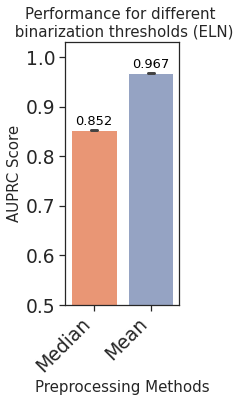

In [6]:
plt.figure(figsize=(3,6))
sns.set(font_scale=1.7, style='ticks')

ax = sns.barplot(data=df_bar, x='Bin_threshold', y='AUPRC',  capsize=.1,
                palette=[sns.color_palette("Set2")[1], sns.color_palette("Set2")[2]])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height()+0.005, '{0:.3f}'.format(p.get_height()), 
        fontsize=13, color='black', ha='center', va='bottom')
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right')

plt.title('Performance for different \n binarization thresholds (ELN)', fontsize=15)
plt.xlabel("Preprocessing Methods", fontsize=15)
plt.ylabel("AUPRC Score", fontsize=15)

plt.ylim(0.5, 1.03)
plt.tight_layout()
plt.savefig('../figures/S9A_bar_AUPRC.pdf')
plt.show()

## 2. bootstrap_clock <a name="2.-svz"></a>

In [7]:
cell_types = ['Oligodendrocyte', 'Astrocyte','Microglia']
for i in cell_types:
    file = open('../results/cell_type_best/' + i + '_eln_model_test_scores.save', 'rb')
    locals()[i]  = pickle.load(file)
    file.close()

In [8]:
for i in cell_types:
    file = open('../results/cell_type_best/' + i + '_eln_model_test_models.save', 'rb')
    all_10_files = pickle.load(file)
    model  = all_10_files[0]
    file.close()

In [9]:
df_bar = pd.DataFrame(columns=['Cell-type', 'Method', 'AUPRC'])
# results from svz_clock___.R files
df_bar = df_bar.append({"Cell-type": "Oligodendrocyte", "Method": "bootstrap_clock", "AUPRC": 0.9257541}, ignore_index=True)
df_bar = df_bar.append({"Cell-type": "Astrocyte", "Method": "bootstrap_clock", "AUPRC": 0.933159}, ignore_index=True)
df_bar = df_bar.append({"Cell-type": "Microglia", "Method": "bootstrap_clock", "AUPRC": 0.9684949}, ignore_index=True)

df_bar

,Cell-type,Method,AUPRC
0,Oligodendrocyte,bootstrap_clock,0.925754
1,Astrocyte,bootstrap_clock,0.933159
2,Microglia,bootstrap_clock,0.968495


In [10]:
for i in cell_types:
    df_new = pd.DataFrame(columns=['Cell-type', 'Method', 'AUPRC'], index=[0])
    df_new['Cell-type'] = i
    df_new['Method'] = 'CellBiAge'
    df_new['AUPRC'] = locals()[i][0]
    df_bar = df_bar.append(df_new)

In [11]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

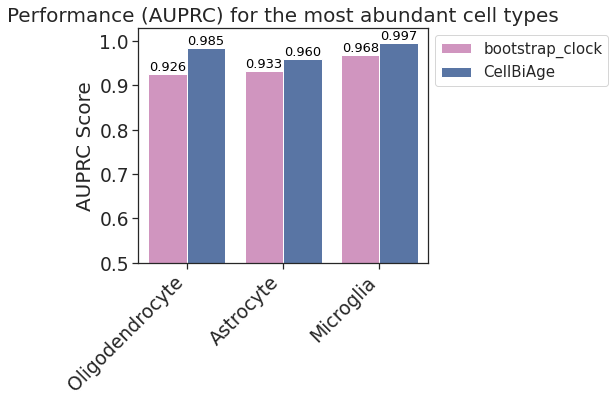

In [12]:
sns.color_palette()

plt.figure(figsize=(8,6))
sns.set(font_scale=1.7, style='ticks')

ax = sns.barplot(data=df_bar, x='Cell-type', y='AUPRC', hue='Method',
                 palette=[sns.color_palette()[6], sns.color_palette()[0]])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.3f}'.format(p.get_height()), 
        fontsize=13, color='black', ha='center', va='bottom')

plt.title('Performance (AUPRC) for the most abundant cell types', fontsize=20)
plt.xlabel("", fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.ylabel("AUPRC Score", fontsize=20)
plt.ylim(0.5, 1.03)
plt.legend(title='', bbox_to_anchor=(1, 1), fontsize=15)
plt.tight_layout()
plt.savefig('../figures/S9B_celltypes_bar_AUPRC_2.pdf')
plt.show()